In [329]:
%matplotlib inline 
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import multiprocessing


import torchvision
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.optim as optim

In [ ]:
import cv2

In [52]:
class FaceDetection():
    
    def __init__(self, path2img = 'figures/fig.jpg', path2class = '/Users/renatobottermaiolopesrodrigues/anaconda3/share/OpenCV/haarcascades/haarcascade_frontalface_alt.xml'):
        
        #Load image
        self.img_original = cv2.imread(path2img)
        
        # Convert to RGB colorspace
        self.img_original = self.convertToRGB(self.img_original)
        
        # copy original image
        self.img_with_detections = np.copy(self.img_original)
        
        #convert image to gray (opencv expects gray images)
        self.gray_img = self.convertToGray(self.img_original)

        #load cascade classifier (haarcascade) training file
        self.haar_face_cascade = cv2.CascadeClassifier(path2class)

        #Detect multiscale images 
        self.faces = self.haar_face_cascade.detectMultiScale(self.gray_img, scaleFactor=1.1, minNeighbors=5);

    def number_faces(self):
        #print the number of faces found 
        print('Faces found: ', len(self.faces))

    def convertToGray(self, img):
        # Convert the RGB  image to grayscale
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    def convertToRGB(self, img):
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    
    def detection(self):
    
        faces_crop = []
        for (x, y, w, h) in self.faces:  
            obj = self.img_with_detections[y:y + h, x:x + w]
            faces_crop.append(obj)
            cv2.rectangle(self.img_with_detections, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
        return faces_crop

In [53]:
FaceDetection = FaceDetection()

In [54]:
FaceDetection.number_faces()

Faces found:  9


In [55]:
faces_crop = FaceDetection.detection()
(img_original, img_with_detections) =  (FaceDetection.img_original, FaceDetection.img_with_detections)

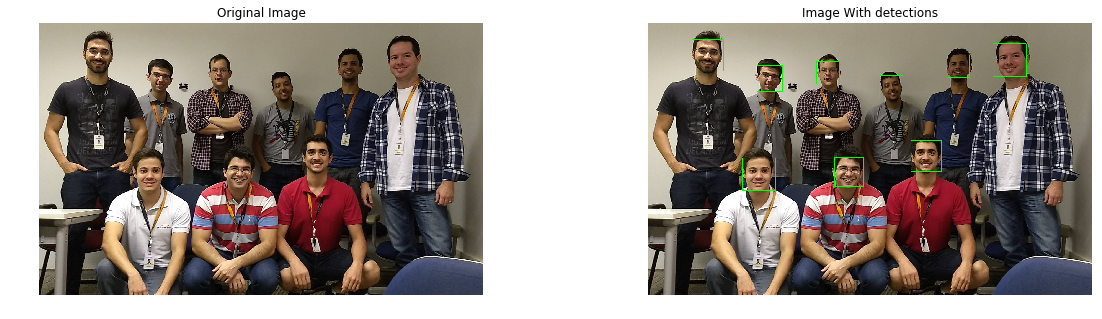

In [56]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(img_original)
plt.title('Original Image')
plt.axis('off')


plt.subplot(1,2,2)
#convert image to RGB and show image 
plt.imshow(img_with_detections)
plt.title('Image With detections')
plt.axis('off')

fig.savefig('figures/fig_detection.png')

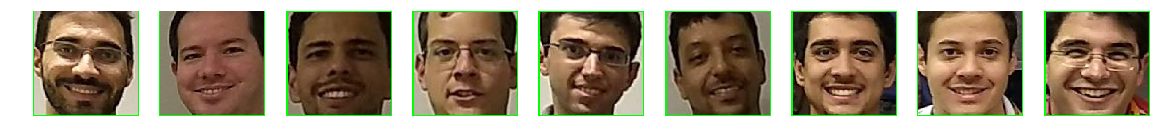

In [57]:
plt.figure(figsize=(20,5))
count = 1
for face in faces_crop:
    plt.subplot(1,len(faces_crop),count)
    count+=1
    plt.imshow(face)
    plt.axis('off')

In [334]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)
cpu_count = multiprocessing.cpu_count()
print('cpu_count: ', cpu_count)

GPU available: False
cpu_count:  12


In [335]:
path2data = '/home/r120084/data/'

In [336]:
path2trainData = path2data + 'train/training.csv'
path2testData = path2data + 'test/test.csv'

In [337]:
batch_size = 32

In [338]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, path2data, val_size = 0.1, dropnan = True, transforms=None,
                 is_valid=False, is_test=False, is_train = False):
        
        
        self.transform = transforms    
        df = pd.read_csv(path2data)
        self.get_columns(df)
        
        if dropnan:
            df = df.dropna()
            
        df['Image'] = df['Image'].apply(lambda img:  np.fromstring(img, sep = ' '))
        self.X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
        self.X = self.X.astype(np.float32)
        self.X = self.X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96
        
        
        if ( (is_train) or (is_valid)):
            self.y = df[df.columns[:-1]].values

            if is_valid:
                self.split_data(val_size)
                
            self.y = (self.y - 48) / 48 
            self.y = self.y.astype(np.float32)

        if is_test:
            self.y = np.zeros([len(df), len(df.columns[:-1])])

    def get_columns(self, df):
        self.columns = df.columns
                 
    def split_data(self, val_size = 0.1):

        np.random.seed(4572)
        indices = range(len(self.X))

        ind = np.random.permutation(indices)
        split = np.round(val_size * len(self.X))
        index= np.array(ind[:split])
        
        self.X = self.X.take(index,axis=0)
        self.y = self.y.take(index,axis=0)
    
    def __getitem__(self, index):
        image = self.X[index]
        keypoints = self.y[index]        
        sample = {'input': image, 'output': keypoints}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

    # documentar no pytorch
    def __len__(self):
        return len(self.X)

In [339]:
class ToTensor(object):

    def __call__(self, sample):
        image, keypoints = sample['input'], sample['output']

        # imagem numpy: C x H x W
        # imagem torch: C X H X W
                    
        image = image.transpose((0, 1, 2))
        return {'input': torch.from_numpy(image),
                'output': torch.from_numpy(keypoints)}

In [342]:
class CloneArray(object):
    
    def __call__(self, sample):
        image, keypoints = sample['input'], sample['output']

        image = image.repeat(3, axis=0)
        return {'input': image,
                'output': keypoints}

In [343]:
data_transforms = {
    'train': transforms.Compose([
        CloneArray(),
        ToTensor()

    ]),
    'valid': transforms.Compose([
        CloneArray(),
        ToTensor()
    ]),
}

In [344]:
dsets = {
    'train': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['train'], is_train = True),
    'valid': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['valid'], is_valid=True),
    'test':  FaceKeyPointsDataset(path2testData, transforms=data_transforms['valid'], is_test=True),
}

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [345]:
if use_gpu:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True, num_workers=cpu_count*2,  pin_memory=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False, num_workers=cpu_count*2,  pin_memory=True),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False, num_workers=cpu_count*2,  pin_memory=True),
    }
else:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, num_workers=cpu_count*2, shuffle=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, num_workers=cpu_count*2, shuffle=False),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, num_workers=cpu_count*2, shuffle=False),
    }

In [346]:
def plot_face_Keypoints(dsets, is_train = True, preds_test = [], preds_train = []):
    
    plt.figure(figsize=(20,5))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)

        rand_img = random.randrange(0, len(dsets))

        X = dsets[rand_img]['input'].numpy()
        img = X.transpose((1, 2, 0))
        img = np.squeeze(img)

        if is_train:
            y =  dsets[rand_img]['output'].numpy()
        else:
            y = preds_test.numpy()[rand_img]

        cordinates = y * 48 + 48

        plt.imshow(img, cmap = 'gray')
        if (len(preds_train) !=0):
            plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
            y_train = preds_train.numpy()
            cordinates_train = y_train[rand_img]*48 + 48
            plt.scatter(cordinates_train[::2], cordinates_train[1::2], marker='o', c='r', s=10)

        plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
        plt.title('Sample n {}'.format(rand_img))
        plt.axis('off')

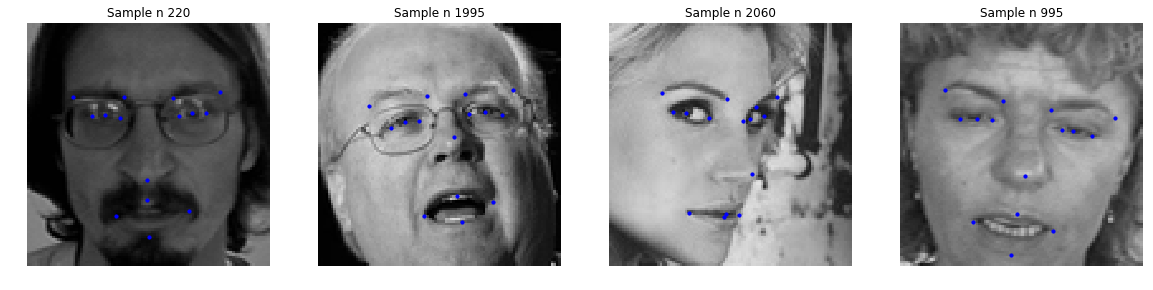

In [347]:
plot_face_Keypoints(dsets['train'])

In [348]:
sample_train = next(iter(dset_loaders['train']))
print(sample_train['input'].size(), sample_train['output'].size())

torch.Size([32, 3, 96, 96]) torch.Size([32, 30])


In [307]:
nb_out = 30

In [308]:
class myconvNet(nn.Module):

    def __init__(self, image_size=(1,96,96)):
        super(myconvNet, self).__init__()  
        
        self.conv1 = nn.Conv2d(image_size[0], 24, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)


        self.conv3 = nn.Conv2d(36, 48, kernel_size=5)
        self.pool3 = torch.nn.MaxPool2d(2, 2)


        self.conv4 = nn.Conv2d(48, 64, kernel_size=5)
        self.pool4 = torch.nn.AvgPool2d(2, 2)
        
        feature_size = self._get_conv_output(image_size)
        
        self.fc1 = nn.Linear(feature_size, 128)    
        self.drop_dense1 = torch.nn.Dropout(0.25)

        self.fc2 = nn.Linear(128, 64)
        self.drop_dense2 = torch.nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, nb_out)

        
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_dense1(x)
        x = F.relu(self.fc2(x))
        x = self.drop_dense2(x)
        x = self.fc3(x)
        return x
    
    
    def _forward_features(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)     
        return x
    
    
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

In [309]:
'''
model = myconvNet()
if use_gpu:
    myconvNet = myconvNet.cuda()  
'''

'\nmodel = myconvNet()\nif use_gpu:\n    myconvNet = myconvNet.cuda()  \n'

In [310]:
class MyResNetConv(torchvision.models.ResNet):
    def __init__(self):
        super().__init__(torchvision.models.resnet.BasicBlock, [2, 2, 2, 2])
        self.load_state_dict(torch.utils.model_zoo.load_url(
            'https://download.pytorch.org/models/resnet18-5c106cde.pth'))
        del self.layer2
        del self.layer3
        del self.layer4
        del self.fc
        for param in self.parameters():
            param.requires_grad = False
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x

class MyResNetDens(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.dens1 = torch.nn.Linear(in_features=64*3*3, out_features=100)
        self.dens2 = torch.nn.Linear(in_features=100, out_features=nb_out)
    def forward(self, x):
        x = self.dens1(x)
        x = torch.nn.functional.selu(x)
        x = self.dens2(x)
        return x

class MyResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mrnc = MyResNetConv()
        self.mrnd = MyResNetDens()
    def forward(self, x):
        x = self.mrnc(x)
        x = self.mrnd(x)
        return x

In [311]:
model = MyResNet()
if use_gpu:
    model.cuda() 

In [312]:
print(model)

MyResNet (
  (mrnc): MyResNetConv (
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (relu): ReLU (inplace)
    (maxpool): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    (layer1): Sequential (
      (0): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      )
      (1): BasicBlock (
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride

In [313]:
def predict(dset_loaders, model, get_labels = False):

    predictions = []
    labels_lst = []
    ii_n = len(dset_loaders)

    for i, data in enumerate(dset_loaders):
        inputs, labels = data['input'], data['output']
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        inputs = Variable(inputs)
        predictions.append(model(inputs).data)
        
        if get_labels:
            labels_lst.append(labels)


        print('\rpredict: {}/{}'.format(i, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return {'input': torch.cat(predictions, 0), 'ouput':torch.cat(labels_lst, 0) }

In [314]:
convOutput_train = predict(dset_loaders['train'], model.mrnc, get_labels= True)
convOutput_valid = predict(dset_loaders['valid'], model.mrnc, get_labels= True)

predict: 66/66 ok
predict: 6/6 ok


In [315]:
print(convOutput_train['input'].size(), convOutput_train['ouput'].size())
print(convOutput_valid['input'].size(), convOutput_valid['ouput'].size())

torch.Size([2140, 576]) torch.Size([2140, 30])
torch.Size([214, 576]) torch.Size([214, 30])


In [316]:
trainset = TensorDataset(convOutput_train['input'], convOutput_train['ouput'])
validset = TensorDataset(convOutput_valid['input'], convOutput_valid['ouput'])

In [317]:
if use_gpu:
    dset_loaders_convnet = {
        'train': DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=cpu_count*2,  pin_memory=True),
        'valid': DataLoader(validset, batch_size=batch_size, shuffle=False, num_workers=cpu_count*2,  pin_memory=True),
    }
else:
    
    dset_loaders_convnet = {
        'train': DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count*2, shuffle=True),
        'valid': DataLoader(validset, batch_size=batch_size, num_workers=cpu_count*2, shuffle=False),
    }

In [318]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, (data) in enumerate(loader):     
        #inputs, labels = data['input'], data['output']
        inputs, labels = data


        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [319]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    history_loss = []
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    patience_count= 0
    for epoch in range(num_epochs):
        for i, (data) in enumerate(train_loader):
            
            #inputs, labels = data['input'], data['output']
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(evaluate_model(train_loader, model,loss_fn) )
        loss_test.append( evaluate_model(test_loader, model,loss_fn) )
        history_loss.append(loss.data[0])
        
        print('Epoch:', epoch, ' Loss Train: ', loss_train[-1],  ' Lost Test: ', loss_test[-1])

        #Early stopping
        if(best_test_acc < loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('Done!')
    return history_loss, loss_train, loss_train, model 

In [320]:
'''
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(myconvNet.parameters()) 
optimizer =  optim.RMSprop(model.parameters(), lr=1e-3)
#lr = 0.1
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
num_epochs = 5
patience = 2 
'''

'\nloss_fn = torch.nn.MSELoss()\n#optimizer = torch.optim.Adam(myconvNet.parameters()) \noptimizer =  optim.RMSprop(model.parameters(), lr=1e-3)\n#lr = 0.1\n#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)\nnum_epochs = 5\npatience = 2 \n'

In [321]:
loss_fn = torch.nn.MSELoss()
optimizer =  optim.RMSprop(model.mrnd.parameters(), lr=1e-3)
num_epochs = 50
patience = 10

In [322]:
params = {'model' : model.mrnd, 
        'train_loader':dset_loaders_convnet['train'],
         'test_loader':dset_loaders_convnet['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
        'optimizer': optimizer, 
         'patience': patience 
         }

In [323]:
history_loss, loss_train, loss_train, model.mrnd   = train(**params)

Epoch: 0  Loss Train:  0.01442145708609711  Lost Test:  0.016882210038602352
Epoch: 1  Loss Train:  0.007216275810743823  Lost Test:  0.008249960839748383
Epoch: 2  Loss Train:  0.034030331609149776  Lost Test:  0.038680764536062874
Epoch: 3  Loss Train:  0.02169384400952946  Lost Test:  0.02476536389440298
Epoch: 4  Loss Train:  0.01864802326555505  Lost Test:  0.021703193585077923
Epoch: 5  Loss Train:  0.019071578979492188  Lost Test:  0.02240150235593319
Epoch: 6  Loss Train:  0.012124338723493345  Lost Test:  0.013713970625152191
Epoch: 7  Loss Train:  0.026113688635329407  Lost Test:  0.02992028370499611
Epoch: 8  Loss Train:  0.008042761667942008  Lost Test:  0.009244212880730629
Epoch: 9  Loss Train:  0.010968459120979815  Lost Test:  0.012731172610074282
Epoch: 10  Loss Train:  0.019988091718969925  Lost Test:  0.02295832832654317
Epoch: 11  Loss Train:  0.010027125435457989  Lost Test:  0.011500497038165728
Done!


In [324]:
def predict_conv(model, dset_loaders, use_gpu = False):

    predictions = []
    if use_gpu:
        use_gpu = torch.cuda.is_available()

    model.train(False)  # Set model to evaluate mode
    ii_n = len(dset_loaders)
    for ii, data in enumerate(dset_loaders):
        try:
            image, labels = data['input'], data['output']
        except:
            image, labels = data

        if use_gpu:
            image = Variable(image.cuda())
        else:
            image = Variable(image)
        outputs = model(image)
        predictions.append(outputs.data.cpu())
        print('\rpredict: {}/{}'.format(ii, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return torch.cat(predictions, 0)

In [325]:
preds_test = predict_conv(model, dset_loaders['test'])
preds_train = predict_conv(model, dset_loaders['train'])

predict: 55/55 ok
predict: 66/66 ok


In [326]:
(preds_test.shape, preds_train.shape)

(torch.Size([1783, 30]), torch.Size([2140, 30]))

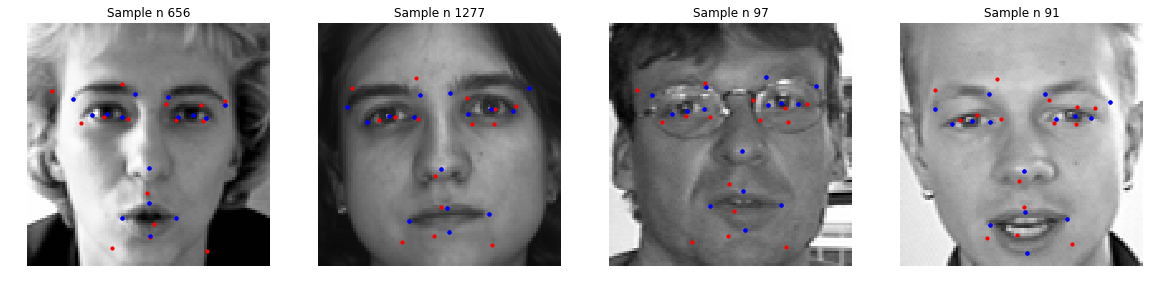

In [327]:
plot_face_Keypoints(dsets['train'],  preds_train = preds_train)

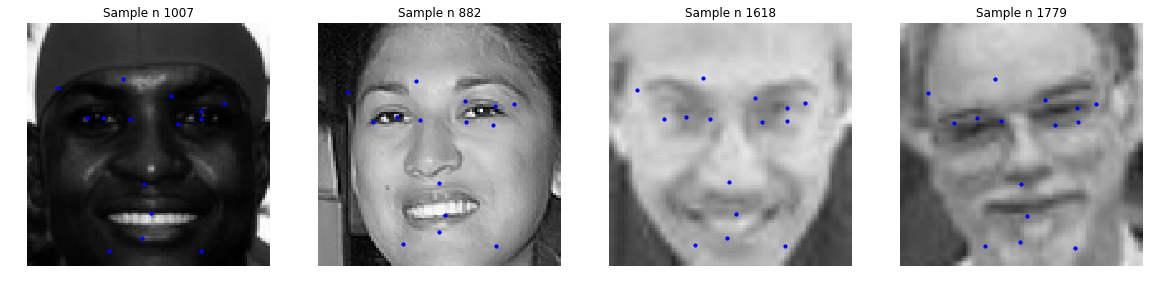

In [328]:
plot_face_Keypoints(dsets['test'], is_train= False,  preds_test = preds_test)

In [26]:
id_lookup_frame = pd.read_csv(path2data + "IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [50]:
y_test= preds_test.numpy() * 48  + 48
columns = dsets['train'].columns[:-1]

In [ ]:
def generate_output_submission(y_test, columns, filename = "result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1,:])
            j += 30
        else:
            slice_img = y_test[i-1, :]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [ ]:
generate_output_submission(y_test, columns)

In [ ]:
print('Done!')